In [1]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [2]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True, as_supervised=True)

train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [4]:
for example, label in train_dataset.take(1):
    print('text: ', example.numpy())
    print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [6]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [7]:
for example, label in train_dataset.take(1):
    print('texts: ', example.numpy()[:3])
    print('labels: ', label.numpy()[:3])

texts:  [b'The Life and Time of Little Richard, as told by Little Richard, as produced and directed by Little Richard, was about as one sided as one of his songs. This is not a biography or even a docudrama, but does have good writing, great energy and an outstanding leading actor playing Richard. All the music is by Little Richard, so it rocks a tight lipsync on every song.<br /><br />The movie covers his early childhood, carrys thru the formative years in music, the wild success and Richard\'s throwing it all away to praise the Lord. Its all tied together well and the obvious comeback in 1962 manages to stay away from the idea that Little Richard discovered the Beatles, whom opened for him.<br /><br />My main objection is that his outrageous, counter cultural behavior is underplayed and you get no feel for how his audience experienced him at that time. Some of his energy, which he still has, does not come across full force. He seemed tame, compared to what I remember of him at the ti

In [8]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE
)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [9]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [10]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[  2, 119,   3, ...,   0,   0,   0],
       [  1,  50,   2, ...,   0,   0,   0],
       [101, 308,   2, ...,   0,   0,   0]])

In [11]:
for n in range(3):
    print("Original: ", example[n].numpy())
    print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
    print()

Original:  b'The Life and Time of Little Richard, as told by Little Richard, as produced and directed by Little Richard, was about as one sided as one of his songs. This is not a biography or even a docudrama, but does have good writing, great energy and an outstanding leading actor playing Richard. All the music is by Little Richard, so it rocks a tight lipsync on every song.<br /><br />The movie covers his early childhood, carrys thru the formative years in music, the wild success and Richard\'s throwing it all away to praise the Lord. Its all tied together well and the obvious comeback in 1962 manages to stay away from the idea that Little Richard discovered the Beatles, whom opened for him.<br /><br />My main objection is that his outrageous, counter cultural behavior is underplayed and you get no feel for how his audience experienced him at that time. Some of his energy, which he still has, does not come across full force. He seemed tame, compared to what I remember of him at the 

In [12]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [13]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [14]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

In [15]:
predictions[0]

array([-0.00013283], dtype=float32)

In [16]:
padding = "the " * 200

In [17]:
[sample_text, padding]

['The movie was cool. The animation and the graphics were out of this world. I would recommend this movie.',
 'the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the ']

In [18]:
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[-0.00013283]


In [19]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 64)          64000     
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               66048     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 138,369
Trainable params: 138,369
Non-trainable params: 0
_________________________________________________________________


In [20]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 26s 57ms/step - loss: 0.6365 - accuracy: 0.5736 - val_loss: 0.4916 - val_accuracy: 0.7375

In [21]:
test_loss, test_acc = model.evaluate(test_dataset)

print("Test Loss: ", test_loss)
print("Test Accuracy: ", test_acc)

391/391 [==============================] - 8s 20ms/step - loss: 0.3179 - accuracy: 0.8561

(0.0, 0.6533384278416634)

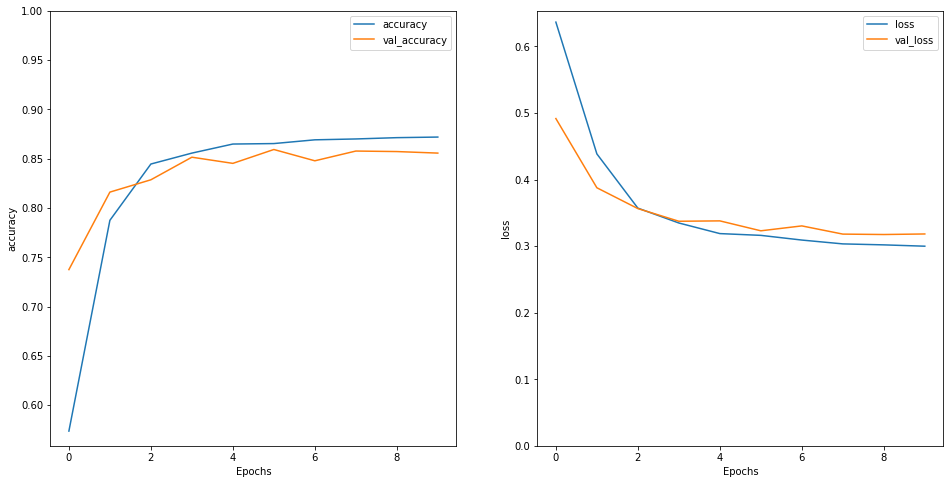

In [22]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [23]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

In [24]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [25]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [26]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 44s 87ms/step - loss: 0.6154 - accuracy: 0.5937 - val_loss: 0.4219 - val_accuracy: 0.8323